In this notebook, we will demonstrate how to run Logistic Regression and Linear Discriminant analysis on the Boston data set. We will show how to fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [1]:
library(ISLR)
library(MASS)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


# 1. The Boston Housing Dataset

In [2]:
attach(Boston)

In [3]:
str(Boston)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [4]:
summary(Boston)

      crim                zn             indus            chas        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   Min.   :0.00000  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1st Qu.:0.00000  
 Median : 0.25651   Median :  0.00   Median : 9.69   Median :0.00000  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14   Mean   :0.06917  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10   3rd Qu.:0.00000  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74   Max.   :1.00000  
      nox               rm             age              dis        
 Min.   :0.3850   Min.   :3.561   Min.   :  2.90   Min.   : 1.130  
 1st Qu.:0.4490   1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100  
 Median :0.5380   Median :6.208   Median : 77.50   Median : 3.207  
 Mean   :0.5547   Mean   :6.285   Mean   : 68.57   Mean   : 3.795  
 3rd Qu.:0.6240   3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188  
 Max.   :0.8710   Max.   :8.780   Max.   :100.00   Max.   :12.127  
      rad              tax 

In [5]:
sapply(Boston[, -14], sd)

crim          zn       indus        chas         nox          rm 
  8.6015451  23.3224530   6.8603529   0.2539940   0.1158777   0.7026171 
        age         dis         rad         tax     ptratio       black 
 28.1488614   2.1057101   8.7072594 168.5371161   2.1649455  91.2948644 
      lstat 
  7.1410615

## 1.1 Create response variable 
We are going to introduce a variable whether or not the crime rate is above or below the median.
If the crime rate is above the median, the response variable is set to 1, otherwise 0.

In [6]:
Boston$resp <- "No"
Boston$resp[crim > median(crim)] <- 'Yes'
Boston$resp <- factor(Boston$resp)
table(Boston$resp)


 No Yes 
253 253 

Now, we can drop the old crime variable.

In [7]:
Boston <- Boston[-drop(1)]
head(Boston)

zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,resp
18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,No
0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,No
0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,No
0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,No
0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,No
0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,No


The next thing we need to do is create training and testing data.

In [8]:
inTrain <- createDataPartition(y = Boston$resp, p = 0.80, list = FALSE)
train <- Boston[inTrain,]
test <- Boston[-inTrain,]

In [9]:
table(train$resp)
table(test$resp)


 No Yes 
203 203 


 No Yes 
 50  50 

## 1.2 Identification of near zero variance predictors

Now, let's check the near zero variance predictors, which have the following two characteristics
    1. They have very few unique values relative to the number of samples
    2. the ratio of the frequency of the most common value to the frequency of the second most common value is large
    
This kind of predictor is not only non-informative, it can break some models you may want to fit to your data. For example, we usually break a categorical variable with many categories into several dummy variables. Hence, when one of the categories have zero observations, it becomes a dummy variable full of zeros.    

the function nearZeroVar from the caret can help us idenfity those near zero variance predictors.

In [10]:
nzv <- nearZeroVar(Boston, saveMetrics = TRUE)
nzv

,freqRatio,percentUnique,zeroVar,nzv
zn,17.714286,5.1383399,FALSE,FALSE
indus,4.400000,15.0197628,FALSE,FALSE
chas,13.457143,0.3952569,FALSE,FALSE
nox,1.277778,16.0079051,FALSE,FALSE
rm,1.000000,88.1422925,FALSE,FALSE
age,10.750000,70.3557312,FALSE,FALSE
dis,1.250000,81.4229249,FALSE,FALSE
rad,1.147826,1.7786561,FALSE,FALSE
tax,3.300000,13.0434783,FALSE,FALSE
ptratio,4.117647,9.0909091,FALSE,FALSE


The result given by the nearZeroVar function shows that no variables are near zero variance.

## 1.3 Check the correlation between each pair of predictors.

In [11]:
Boston_cor <- cor(Boston[,-14])
Boston_cor

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
zn,1.00000000,-0.53382819,-0.042696719,-0.51660371,0.31199059,-0.56953734,0.66440822,-0.311947826,-0.31456332,-0.3916785,0.17552032,-0.4129946,0.3604453
indus,-0.53382819,1.00000000,0.062938027,0.76365145,-0.39167585,0.64477851,-0.70802699,0.595129275,0.72076018,0.3832476,-0.35697654,0.6037997,-0.4837252
chas,-0.04269672,0.06293803,1.000000000,0.09120281,0.09125123,0.08651777,-0.09917578,-0.007368241,-0.03558652,-0.1215152,0.04878848,-0.0539293,0.1752602
nox,-0.51660371,0.76365145,0.091202807,1.00000000,-0.30218819,0.73147010,-0.76923011,0.611440563,0.66802320,0.1889327,-0.38005064,0.5908789,-0.4273208
rm,0.31199059,-0.39167585,0.091251225,-0.30218819,1.00000000,-0.24026493,0.20524621,-0.209846668,-0.29204783,-0.3555015,0.12806864,-0.6138083,0.6953599
age,-0.56953734,0.64477851,0.086517774,0.73147010,-0.24026493,1.00000000,-0.74788054,0.456022452,0.50645559,0.2615150,-0.27353398,0.6023385,-0.3769546
dis,0.66440822,-0.70802699,-0.099175780,-0.76923011,0.20524621,-0.74788054,1.00000000,-0.494587930,-0.53443158,-0.2324705,0.29151167,-0.4969958,0.2499287
rad,-0.31194783,0.59512927,-0.007368241,0.61144056,-0.20984667,0.45602245,-0.49458793,1.000000000,0.91022819,0.4647412,-0.44441282,0.4886763,-0.3816262
tax,-0.31456332,0.72076018,-0.035586518,0.66802320,-0.29204783,0.50645559,-0.53443158,0.910228189,1.00000000,0.4608530,-0.44180801,0.5439934,-0.4685359
ptratio,-0.39167855,0.38324756,-0.121515174,0.18893268,-0.35550149,0.26151501,-0.23247054,0.464741179,0.46085304,1.0000000,-0.17738330,0.3740443,-0.5077867


In [12]:
highCor <- findCorrelation(Boston_cor, cutoff = 0.75)
highCor

[1] 2 4 9

The [findCorrelation](http://www.inside-r.org/packages/cran/caret/docs/findCorrelation) function returns a vector of integers corresponding to columns to remove to reduce pair-wise correlations. It shows that <font color='red'>indus</font> and <font color='red'>nox</font> are highly correlated, and <font color='red'>indus</font> is highly correlated with <font color='red'>tax</font>. For the demonstration purpose, we will remove <font color='red'>nox</font> and <font color='red'>tax</font>

In [13]:
train_cor <- train[,-drop(c(2,9))]
test_cor <- test[,-drop(c(2,9))]

# 2. Logistic regression model

## 2.1 Training a logistic regression model and interpret it

In [14]:
logit <- train(resp~., data=train, method='glm', family=binomial(link='logit'), preProcess=c('scale', 'center'))

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning mess

If you run the above code and recieve the following error message:
```R
Error in requireNamespaceQuietStop("e1071"): package e1071 is required
```
please install the e1071 package with the following command 
```
install.packages('e1071', dependencies=TRUE)
```

In [15]:
summary(logit)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6848  -0.1373  -0.0005   0.0021   3.4994  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.28147    0.89908   3.650 0.000262 ***
zn          -1.50194    0.90310  -1.663 0.096293 .  
indus       -0.38805    0.38838  -0.999 0.317727    
chas         0.31728    0.20790   1.526 0.126972    
nox          5.83701    0.99281   5.879 4.12e-09 ***
rm          -0.42020    0.60887  -0.690 0.490115    
age          0.96787    0.40365   2.398 0.016495 *  
dis          1.53870    0.56053   2.745 0.006049 ** 
rad          5.60037    1.55786   3.595 0.000325 ***
tax         -1.39791    0.54743  -2.554 0.010663 *  
ptratio      0.97173    0.34761   2.795 0.005183 ** 
black       -3.44377    1.29773  -2.654 0.007962 ** 
lstat       -0.04404    0.42200  -0.104 0.916886    
medv         1.58698    0.74196   2.139 0.032442 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' '

* In the output above, the first thing we see is the call, this is R reminding us what the model we ran was, what options we specified, etc.

* Next we see the deviance residuals, which are a measure of model fit. This part of output shows the distribution of the deviance residuals for individual cases used in the model. Below we discuss how to use summaries of the deviance statistic to assess model fit.
    * **Deviance residual** is a generalization of the idea of using the sum of squares of residuals in ordinary least squares to cases where model-fitting is achieved by maximum likelihood.
    * Deviance residuals and regular residuals should have similar properties. Like the residuals in linear regression, the deviance residuals shown in the result should looks roughly symmetric. 

* The next part of the output shows the coefficients, their standard errors, the z-statistic (sometimes called a Wald z-statistic), and the associated p-values. Both nox and rad are statistically significant.
    * **Z-value**: The z-value is the regression coefficient divided by its standard error. It is also sometimes called the z-statistic. If the z-value is too big in magnitude (i.e., either too positive or too negative), it indicates that the corresponding true regression coefficient is not 0 and the corresponding X-variable matters. When to use t-value v.s. z-value?
    <img src="http://www.statisticshowto.com/wp-content/uploads/2013/08/t-score-vs.-z-score.png">
    * Coefficient interpretation: The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.
        * For every one unit change in nox, the log odds of crime  (versus non-crime) increases by  5.6775.
        * For a one unit increase in rad, the log odds of crime increases by 4.7558.

Note: The relationship between the regression coefficient, its standard error, the z-value, and the p-value is virtually identical both logistic regression and regular least-squares regression. So if you understand this is regular regression, you also understand it in logistic regression.

* Below the table of coefficients are fit indices, including the null and deviance residuals and the AIC. Later we show an example of how you can use these values to help assess model fit.
    * **Null deviance** indicates that if we assume the model is constant. In other words, the null deviance shows how well the response variable is predicted by a model that includes only the intercept
    * **Residual deviance** indicates how well the response variable is predicted with your model.
    * **The Akaike Information Criterion (AIC)** provides a method for assessing the quality of your model through comparison of related models.  It’s based on the Deviance, but penalizes you for making the model more complicated.  Much like adjusted R-squared, it’s intent is to prevent you from including irrelevant predictors. If you have more than one similar candidate models (where all of the variables of the simpler model occur in the more complex models), then you should select the model that has the smallest AIC. AIC estimates the relative information lost by a given model: the less information a model loses, the higher the quality of that model
* **Fisher’s scoring algorithm** is a derivative of Newton’s method for solving maximum likelihood problems numerically. For the model above we see that Fisher’s Scoring Algorithm needed six iterations to perform the fit.This doesn’t really tell you a lot that you need to know, other than the fact that the model did indeed converge, and had no trouble doing it.


We can use the `confint` function to obtain confidence intervals for the coefficient estimates. Note that for logistic models, confidence intervals are based on the profiled log-likelihood function.

In [16]:
cbind(coef= coef(logit$finalModel), confint(logit$finalModel))

Waiting for profiling to be done...
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities nume

"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fi

,coef,2.5 %,97.5 %
(Intercept),3.2814733,1.6023931,5.13428092
zn,-1.5019405,-3.4628951,0.03057966
indus,-0.3880474,-1.1804949,0.36499988
chas,0.3172821,-0.0895728,0.73260867
nox,5.8370106,4.0346887,7.94693866
rm,-0.4201961,-1.6251824,0.77788671
age,0.9678683,0.1992879,1.79315046
dis,1.5387040,0.4803712,2.69390372
rad,5.6003651,2.8750499,8.88527919
tax,-1.3979088,-2.5604828,-0.37318001


Let's have a look at how important each variable is in the current model.

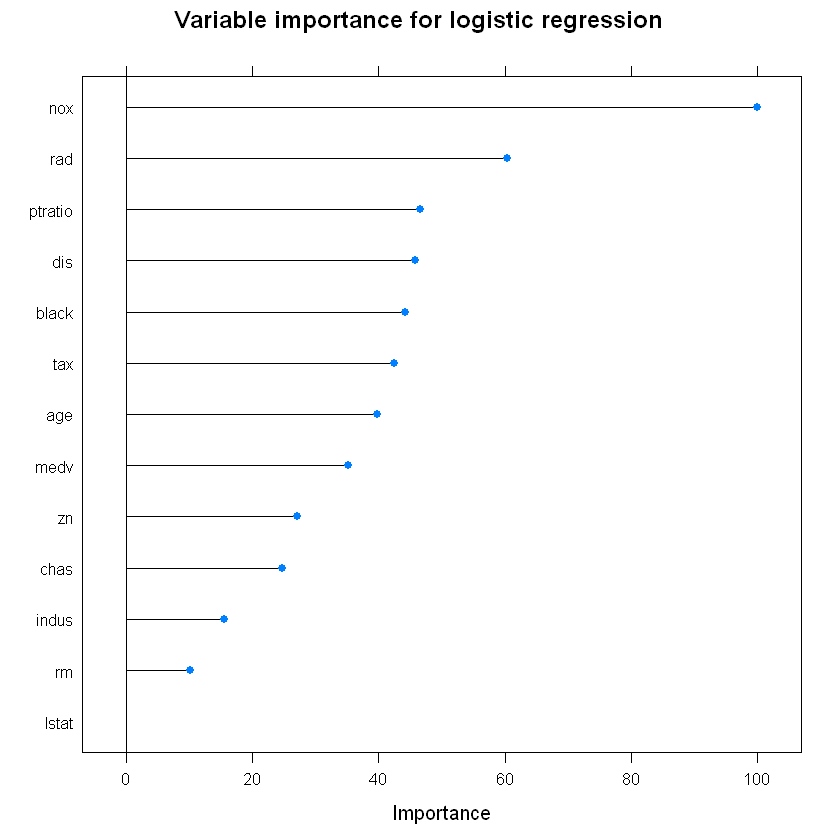

In [17]:
plot(varImp(logit, scale = TRUE), main = "Variable importance for logistic regression")

## 2.1 Measures of how well our model fits. 

This can be particularly useful when comparing competing models. The output produced by summary(logit) include the null and deviance residuals and the AIC. One measure of model fit is the significance of the overall model. This test asks whether the model with predictors fits significantly better than a model with just an intercept (i.e., a null model). The test statistic is the difference between the residual deviance for the model with predictors and the null model. The test statistic is distributed chi-squared with degrees of freedom equal to the differences in degrees of freedom between the current and the null model (i.e., the number of predictor variables in the model). 

To find the difference in deviance for the two models (i.e., the test statistic) we can use the command:

In [18]:
with(logit$finalModel, null.deviance - deviance)

[1] 410.2963

The degrees of freedom for the difference between the two models is equal to the number of predictor variables in the mode, and can be obtained using:

In [19]:
with(logit$finalModel, df.null - df.residual)

[1] 13

Finally, the p-value can be obtained using 

In [20]:
with(logit$finalModel, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE))

[1] 1.493468e-79

The chi-square of 386.34 with 13 degrees of freedom and an associated p-value of less than 0.001 tells us that our model as a whole fits significantly better than an empty model. This is sometimes called a likelihood ratio test (the deviance residual is -2*log likelihood).

You can also use the ANOVA test to compare models as we did in linear regression.

## 2.2 Accessing the predictive ability of the model

The function confusionMatrix can also be used to summarize the results of a classification model.

In [21]:
confusionMatrix(predict(logit, test[,-14]), test$resp)

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  46   6
       Yes  4  44
                                         
               Accuracy : 0.9            
                 95% CI : (0.8238, 0.951)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.8            
 Mcnemar's Test P-Value : 0.7518         
                                         
            Sensitivity : 0.9200         
            Specificity : 0.8800         
         Pos Pred Value : 0.8846         
         Neg Pred Value : 0.9167         
             Prevalence : 0.5000         
         Detection Rate : 0.4600         
   Detection Prevalence : 0.5200         
      Balanced Accuracy : 0.9000         
                                         
       'Positive' Class : No             
                                         

The 0.93 accuracy on the test set is quite a good results. However, keep in mind that this result is dependent on the way of splitting the whole data set into training and testing sets. Therefore, if you which for a more precise score, you would be better off running kind of cross-validation such as k-fold cross validation, which will be covered later.


What are the other statistics? For example,

* No information rate:  the largest proportion of the observed classes
* P-Value [Acc > NIR]: A hypothesis test is also computed to evaluate whether the overall accuracy rate is greater than the rate of the largest class
* Sensitivity: the percentage of suburbs having crime rate below median that are correctly identified. 
* Specificity: the percentage of suburbs having crime rate above median that are correctly identified.

Refer to [Measure model performance](http://topepo.github.io/caret/other.html) for detailed discussion.

Now we are going to plot the ROC curve 

In [22]:
# install.packages("pROC", repos='http://cran.us.r-project.org')
library(pROC)

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [23]:
logit.probs <- predict(logit, test[,-14], type="prob")
head(logit.probs)

,No,Yes
5,0.8244575,0.1755425
10,0.7225959,0.2774041
11,0.8818964,0.1181036
12,0.8455835,0.1544165
18,0.3708158,0.6291842
23,0.5620831,0.4379169


In [24]:
logit.ROC <- roc(predictor=logit.probs$Yes, response=test$resp, levels=rev(levels(test$resp)))

In [25]:
logit.ROC$auc

Area under the curve: 0.9536

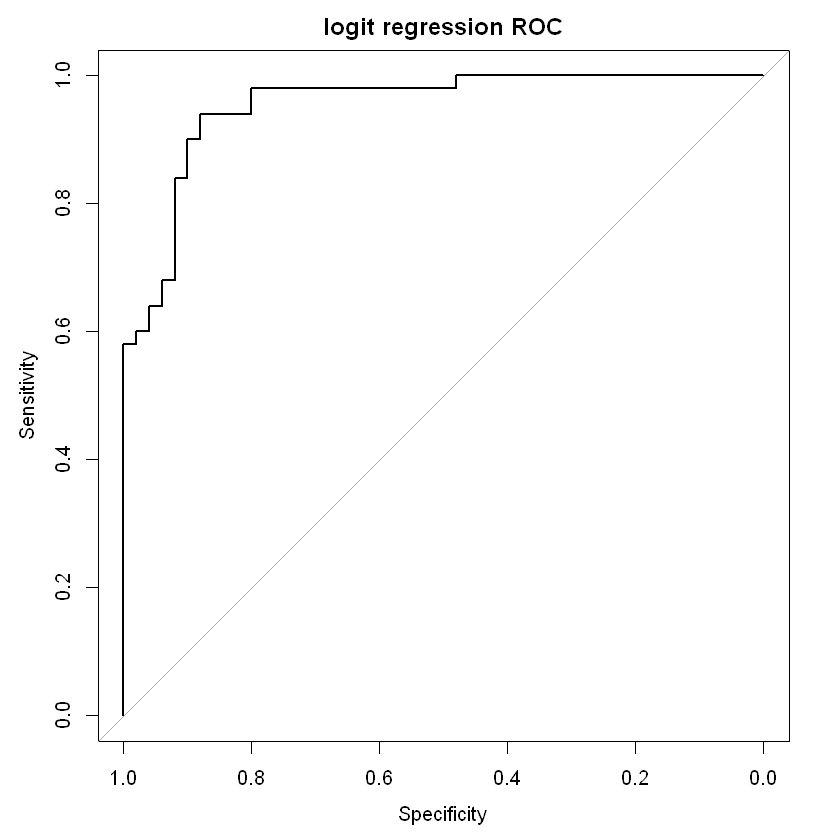

In [26]:
plot(logit.ROC,main="logit regression ROC")

## 2.3 Refine the model with less predictors

Now we can run the `anova()` function to analyze the table of deviance.

In [27]:
anova(logit$finalModel, test = "Chisq")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,405,562.8355,NA
zn,1,108.59901999,404,454.2365,1.986729e-25
indus,1,86.63171643,403,367.6048,1.307336e-20
chas,1,1.13969171,402,366.4651,2.857175e-01
nox,1,127.38578186,401,239.0793,1.529550e-29
rm,1,7.18222537,400,231.8971,7.362933e-03
age,1,0.01356578,399,231.8835,9.072783e-01
dis,1,9.99610968,398,221.8874,1.568713e-03
rad,1,42.86306380,397,179.0243,5.870872e-11
tax,1,6.78252505,396,172.2418,9.205458e-03


The difference between the null deviance and the residual deviance shows how our model is doing against the null model. Analyzing the table we can see the drop in deviance when adding each variable one at a time. Again, 
adding zn, indus, nox and rad significantly reduces the residual deviance. The other variables seem to 
improve the model less even though some of them also have a low p-value. A large p-value here indicates
that the model without the variable explains more or less the same amount of variation. Ultimately, what
we would like to see is a significant drop in deviance and the AIC.

Removing the non-significant ones, we keep the four variables, zn, indus, nox and rad.

In [28]:
#library(car)
logit_s <- train(resp ~ zn + indus + rad + nox, data=train, method='glm', family=binomial(link='logit'), preProcess=c('scale', 'center'))
summary(logit_s)


Call:
NULL

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.00748  -0.26179  -0.00486   0.01204   2.83509  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0328     0.6713   3.028 0.002460 ** 
zn           -1.0522     0.6240  -1.686 0.091750 .  
indus        -0.5615     0.2838  -1.979 0.047840 *  
rad           3.9423     1.0539   3.741 0.000183 ***
nox           3.6296     0.6400   5.671 1.42e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 562.84  on 405  degrees of freedom
Residual deviance: 196.92  on 401  degrees of freedom
AIC: 206.92

Number of Fisher Scoring iterations: 8


In [29]:
confusionMatrix(predict(logit_s, test[,-14]), test$resp)

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  47  12
       Yes  3  38
                                          
               Accuracy : 0.85            
                 95% CI : (0.7647, 0.9135)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 2.413e-13       
                                          
                  Kappa : 0.7             
 Mcnemar's Test P-Value : 0.03887         
                                          
            Sensitivity : 0.9400          
            Specificity : 0.7600          
         Pos Pred Value : 0.7966          
         Neg Pred Value : 0.9268          
             Prevalence : 0.5000          
         Detection Rate : 0.4700          
   Detection Prevalence : 0.5900          
      Balanced Accuracy : 0.8500          
                                          
       'Positive' Class : No              
                                          

## 2.4 Variance Inflation Factors

it is a measure of how much the variance of the estimated regression coefficient is "inflated" by the existence of correlation among the predictor variables in the model.

 A VIF of 1 means that there is no correlation among the k-th predictor and the remaining predictor variables, and hence the variance of the k-th coefficient is not inflated at all. The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction.
 
The two VIFs for rad and nox are close to 1, which means that there is nearly no correlation between rad and nox.

In [30]:
library(car)
vif(logit$finalModel)

Loading required package: carData


zn    indus     chas      nox       rm      age      dis      rad 
1.849095 3.028230 1.358422 4.138660 6.598783 2.455701 4.079389 1.981390 
     tax  ptratio    black    lstat     medv 
2.095510 2.435005 1.330015 2.970420 8.574450

In [31]:
vif(logit_s$finalModel)

zn    indus      rad      nox 
1.080571 2.264296 1.105983 2.231010

# Linear Discriminant Analysis

Now, we carry out LDA on the same data set.

In [32]:
LDA <- train(resp~., data = train_cor, method = 'lda', preProcess=c('scale', 'center'))

In [33]:
LDA$finalModel

Call:
lda(x, grouping = y)

Prior probabilities of groups:
 No Yes 
0.5 0.5 

Group means:
           zn        chas        nox         rm        age        dis
No   0.425984 -0.08885984 -0.7345326  0.1604563 -0.6087041  0.6168389
Yes -0.425984  0.08885984  0.7345326 -0.1604563  0.6087041 -0.6168389
           rad    ptratio      black      lstat       medv
No  -0.6472536 -0.2672159  0.3492408 -0.4613124  0.2852916
Yes  0.6472536  0.2672159 -0.3492408  0.4613124 -0.2852916

Coefficients of linear discriminants:
                LD1
zn      -0.13531801
chas     0.03230381
nox      0.94236992
rm       0.03939345
age      0.30305091
dis      0.07671521
rad      0.60745197
ptratio  0.05579898
black   -0.12024296
lstat    0.09131731
medv     0.34458588

The above results show that 
* $\hat\pi_1 = 0.5$ and $\hat\pi_2 = 0.5$ the prior probability of a observation belonging to classes No and Yes respectively.
* Group means show the estimate of $\mu_k$

In [34]:
confusionMatrix(test_cor$resp, predict(LDA, test_cor[,-14]))

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  49   1
       Yes 14  36
                                          
               Accuracy : 0.85            
                 95% CI : (0.7647, 0.9135)
    No Information Rate : 0.63            
    P-Value [Acc > NIR] : 1.043e-06       
                                          
                  Kappa : 0.7             
 Mcnemar's Test P-Value : 0.001946        
                                          
            Sensitivity : 0.7778          
            Specificity : 0.9730          
         Pos Pred Value : 0.9800          
         Neg Pred Value : 0.7200          
             Prevalence : 0.6300          
         Detection Rate : 0.4900          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.8754          
                                          
       'Positive' Class : No              
                                          

# Quadratic Discriminant Analysis

In [35]:
QDA <- train(resp~., data=train_cor, method='qda', preProcess=c('scale', 'center'))
QDA$finalModel

Call:
qda(x, grouping = y)

Prior probabilities of groups:
 No Yes 
0.5 0.5 

Group means:
           zn        chas        nox         rm        age        dis
No   0.425984 -0.08885984 -0.7345326  0.1604563 -0.6087041  0.6168389
Yes -0.425984  0.08885984  0.7345326 -0.1604563  0.6087041 -0.6168389
           rad    ptratio      black      lstat       medv
No  -0.6472536 -0.2672159  0.3492408 -0.4613124  0.2852916
Yes  0.6472536  0.2672159 -0.3492408  0.4613124 -0.2852916

In [36]:
confusionMatrix(test_cor$resp, predict(LDA, test_cor[,-14]))

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  49   1
       Yes 14  36
                                          
               Accuracy : 0.85            
                 95% CI : (0.7647, 0.9135)
    No Information Rate : 0.63            
    P-Value [Acc > NIR] : 1.043e-06       
                                          
                  Kappa : 0.7             
 Mcnemar's Test P-Value : 0.001946        
                                          
            Sensitivity : 0.7778          
            Specificity : 0.9730          
         Pos Pred Value : 0.9800          
         Neg Pred Value : 0.7200          
             Prevalence : 0.6300          
         Detection Rate : 0.4900          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.8754          
                                          
       'Positive' Class : No              
                                          